In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
from scipy import stats
import warnings
import re
import datetime
from package.utils import profile_data ,DotDict, timer, get_config, load_data, merge_data 

## Autoencoder

In [25]:
from package.model_deep import (generate_mock_data, 
                                prepare_data,
                                set_seed,
                                Autoencoder,
                                train_autoencoder,
                                plot_learning_curve,
                                detect_anomalies,
                                extract_embeddings,
                                plot_latent_space
                                )

In [4]:
mock1 = generate_mock_data(n_sales=10000, n_rules=10, fraud_ratio=0.05, seed=42)
mock1

,sales_id,timeunit,flag_fraud,rule_1,rule_2,rule_3,rule_4,rule_5,rule_6,rule_7,rule_8,rule_9,rule_10
0,0,l3,0,-1.487862,-1.125186,0.388819,-1.173873,1.112634,-0.071120,0.085595,-0.278373,0.772848,0.783160
1,1,l3,1,4.182238,3.601215,2.665470,2.039528,3.012423,6.067259,3.677239,3.582941,2.306755,1.086816
2,2,l3,0,0.608267,1.345935,-0.174648,1.360168,-0.189693,0.849585,-2.218570,2.418778,1.495458,-0.284626
3,3,l3,0,-1.972089,0.288028,-1.443926,0.444854,0.411566,-0.941403,1.120967,0.805575,0.975823,0.008858
4,4,l3,0,-1.415524,0.977872,-0.270371,-1.389780,1.352039,2.099408,-0.041248,2.159121,0.091315,-0.380456
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9995,l36,0,0.647493,-0.163831,-1.743780,1.184970,-0.193500,-1.273190,0.773532,-1.803990,2.209333,-0.800634
59996,9996,l36,0,-0.716390,1.700367,-0.933375,0.191027,-1.348096,2.584121,-0.054343,-1.355835,1.124099,0.609250
59997,9997,l36,0,1.066770,-1.592284,-1.706892,1.178747,0.985029,0.364593,-2.039914,-0.325981,0.478952,0.808948
59998,9998,l36,0,1.622065,-0.303766,1.377932,-0.777375,-0.179569,0.607243,-1.106324,-0.591367,0.501293,0.450664


In [5]:
X_train, X_test, y_test, scaler = prepare_data(mock1, timeunit='l3', scale=False)

In [6]:
len(X_train) # train only non-fraud agent

9526

In [7]:
len(X_test) # test with all agent

10000

In [8]:
len(y_test) # เฉลย for all agent

10000

In [9]:
set_seed(42)

### defining the architecture of the autoencoder
- Building the layers (nn.Linear, nn.ReLU, etc.)
- Structuring the encoder and decoder using nn.Sequential
- Defining the forward() function for how data flows through the network
  <br><br>
**But this does not train anything yet.**

In [10]:
X_train.shape[1] # จำนวน features

10

In [11]:
set_seed(42)
model_test = Autoencoder(input_dim=X_train.shape[1], encoding_dim=3, hidden_layers=[6, 4],verbose=True)

# This is only used for testing the model architecture, not training or evaluating on real data.
x = torch.randn(5, X_train.shape[1]) 
output = model_test(x)

Input: torch.Size([5, 10])
Encoder layer 0: torch.Size([5, 6])
Encoder layer 1: torch.Size([5, 6])
Encoder layer 2: torch.Size([5, 4])
Encoder layer 3: torch.Size([5, 4])
Encoder layer 4: torch.Size([5, 3])
Latent space: torch.Size([5, 3])
Decoder layer 0: torch.Size([5, 4])
Decoder layer 1: torch.Size([5, 4])
Decoder layer 2: torch.Size([5, 6])
Decoder layer 3: torch.Size([5, 6])
Decoder layer 4: torch.Size([5, 10])
Output: torch.Size([5, 10])


In [12]:
output

tensor([[ 0.6478, -0.0272,  0.0387,  0.2780, -0.0180, -0.2639,  0.3674,  0.0223,
         -0.1578, -0.3743],
        [ 0.6395, -0.0260,  0.0344,  0.2788, -0.0222, -0.2659,  0.3624,  0.0165,
         -0.1559, -0.3785],
        [ 0.6344, -0.0253,  0.0318,  0.2793, -0.0248, -0.2672,  0.3593,  0.0130,
         -0.1548, -0.3811],
        [ 0.6336, -0.0252,  0.0314,  0.2794, -0.0252, -0.2674,  0.3589,  0.0125,
         -0.1546, -0.3815],
        [ 0.6464, -0.0270,  0.0380,  0.2781, -0.0187, -0.2642,  0.3666,  0.0213,
         -0.1575, -0.3750]], grad_fn=<AddmmBackward0>)

#### train model to learn normal pattern
It trains an Autoencoder model to reconstruct its input, using mean squared error (MSE) as the loss. 
This lets the model learn the “normal pattern” of your data which you'll later use to detect anomalies.

#### loss  function and optimizer

https://docs.pytorch.org/docs/stable/nn.html#loss-functions

| Loss Function                                   | When to Use / Pros                                                                                      |
| ----------------------------------------------- | ------------------------------------------------------------------------------------------------------- |
| **Mean Absolute Error (MAE)** (`nn.L1Loss()`)   | Less sensitive to outliers than MSE; good if you want robustness to large errors.                       |
| **Binary Cross-Entropy (BCE)** (`nn.BCELoss()`) | Use if input features are binary or normalized between 0 and 1. Often used in Variational Autoencoders. |
| **Huber Loss** (`torch.nn.SmoothL1Loss`)        | Combines benefits of MSE and MAE; less sensitive to outliers than MSE.                                  |
| **Custom Loss**                                 | You can define custom losses, e.g., weighted reconstruction errors or perceptual losses for images.     |


https://docs.pytorch.org/docs/stable/optim.html

| Optimizer                     | Description / When to Use                                                             |
| ----------------------------- | ------------------------------------------------------------------------------------- |
| **SGD** (`optim.SGD`)         | Classic stochastic gradient descent; slower but sometimes better generalization.      |
| **RMSProp** (`optim.RMSprop`) | Good for recurrent networks and non-stationary objectives; adapts learning rate.      |
| **AdamW** (`optim.AdamW`)     | Variant of Adam with better weight decay handling; often improves regularization.     |
| **Adagrad** (`optim.Adagrad`) | Adapts learning rate based on frequency of parameter updates; useful for sparse data. |


In [14]:
set_seed(42)

model = Autoencoder(input_dim=X_train.shape[1], encoding_dim=3, hidden_layers=[6, 4],verbose=False)
trained_model , train_losses, val_losses= train_autoencoder(model=model, X_train=X_train, epochs=50, batch_size=64)

Epoch [1/50] - Train Loss: 1.0406, Val Loss: 0.9920
Epoch [2/50] - Train Loss: 0.9559, Val Loss: 0.9178
Epoch [3/50] - Train Loss: 0.8751, Val Loss: 0.8430
Epoch [4/50] - Train Loss: 0.8259, Val Loss: 0.8142
Epoch [5/50] - Train Loss: 0.8055, Val Loss: 0.8058
Epoch [6/50] - Train Loss: 0.7970, Val Loss: 0.7997
Epoch [7/50] - Train Loss: 0.7901, Val Loss: 0.7931
Epoch [8/50] - Train Loss: 0.7855, Val Loss: 0.7899
Epoch [9/50] - Train Loss: 0.7818, Val Loss: 0.7862
Epoch [10/50] - Train Loss: 0.7782, Val Loss: 0.7814
Epoch [11/50] - Train Loss: 0.7719, Val Loss: 0.7689
Epoch [12/50] - Train Loss: 0.7547, Val Loss: 0.7389
Epoch [13/50] - Train Loss: 0.7257, Val Loss: 0.7147
Epoch [14/50] - Train Loss: 0.7102, Val Loss: 0.7063
Epoch [15/50] - Train Loss: 0.7034, Val Loss: 0.6985
Epoch [16/50] - Train Loss: 0.6992, Val Loss: 0.6957
Epoch [17/50] - Train Loss: 0.6965, Val Loss: 0.6935
Epoch [18/50] - Train Loss: 0.6940, Val Loss: 0.6912
Epoch [19/50] - Train Loss: 0.6922, Val Loss: 0.6904
Ep

In [15]:
trained_model

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=10, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=6, bias=True)
    (3): ReLU()
    (4): Linear(in_features=6, out_features=10, bias=True)
  )
)

What the graph shows:
- X-axis: Epochs (how many times the model has seen the training data)
- Y-axis: Loss (how well the model reconstructs input — lower is better)

There are two curves:
- Training Loss: Error on the training data the model learned from
- Validation Loss: Error on unseen data (validation set)

Goal: Both losses should decrease and stay close to each other.

If validation loss starts increasing while training loss decreases, it’s a sign to stop training or apply techniques to reduce overfitting.

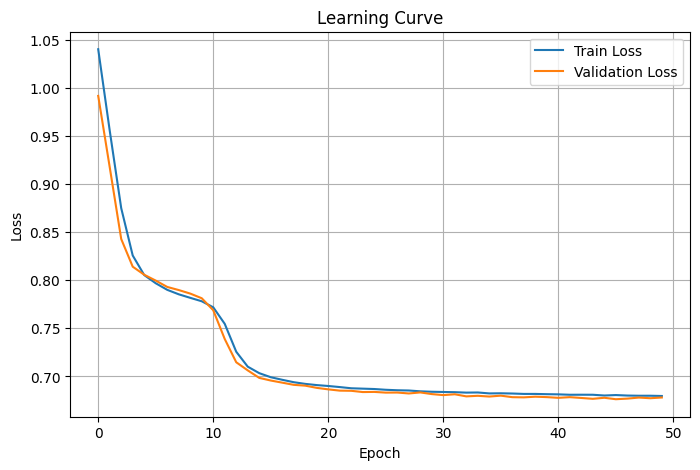

In [17]:
plot_learning_curve(train_losses, val_losses)

In [19]:
# เราใส่ดาต้าทั้งหมดเข้าไปเพื่อเทส (assume ว่าตัวโมเดลเรียนรู้ pattern ความปกติมาแล้ว)
recon_error, predicted_fraud = detect_anomalies(trained_model, X_test, y_test)

Threshold (q=95): 1.3595
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      9526
           1       0.50      1.00      0.66       474

    accuracy                           0.95     10000
   macro avg       0.75      0.97      0.82     10000
weighted avg       0.98      0.95      0.96     10000



In [20]:
recon_error

array([0.38896061, 6.73339827, 0.62410748, ..., 0.24796069, 0.64148895,
       0.57198403], shape=(10000,))

In [21]:
predicted_fraud

array([0, 1, 0, ..., 0, 0, 0], shape=(10000,))

In [27]:
embeddings = extract_embeddings(trained_model, X_test)

In [28]:
embeddings

array([[ -1.1348222 ,  -2.5284314 , -10.981312  ],
       [  3.133273  ,  -6.613969  , -12.462384  ],
       [ -2.435627  ,  -4.055122  ,  -8.388892  ],
       ...,
       [  0.3636504 ,  -1.388049  ,  -3.4400904 ],
       [ -0.06820017,  -2.705068  ,  -9.301918  ],
       [ -0.05512607,  -1.5340537 ,  -4.67263   ]],
      shape=(10000, 3), dtype=float32)

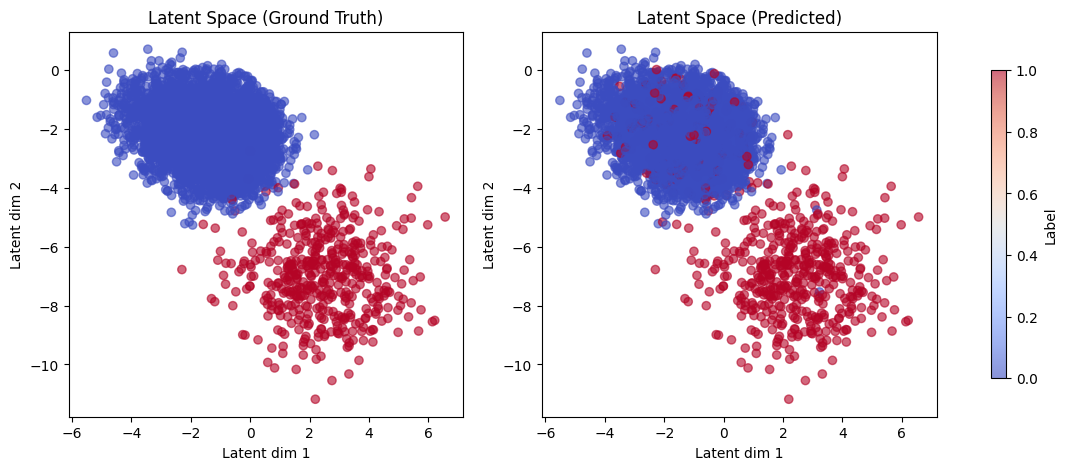

In [36]:
# embeddings = model.encode(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()

# 1. Only true labels
# plot_latent_space(embeddings, y_test=y_test, encoding_dim=3)

# # 2. Only predicted labels
# plot_latent_space(embeddings, y_pred=predicted_fraud, encoding_dim=3)

# # 3. Compare both
plot_latent_space(embeddings, y_test=y_test, y_pred=predicted_fraud, encoding_dim=2)

In [30]:
pd.DataFrame({
    "y_test": pd.Series(y_test).value_counts(),
    "y_pred": pd.Series(predicted_fraud).value_counts()
}).fillna(0).astype(int)

,y_test,y_pred
0,9526,9051
1,474,949


In [40]:
mock1.loc[mock1['timeunit']=='l3',:]

,sales_id,timeunit,flag_fraud,rule_1,rule_2,rule_3,rule_4,rule_5,rule_6,rule_7,rule_8,rule_9,rule_10
0,0,l3,0,-1.487862,-1.125186,0.388819,-1.173873,1.112634,-0.071120,0.085595,-0.278373,0.772848,0.783160
1,1,l3,1,4.182238,3.601215,2.665470,2.039528,3.012423,6.067259,3.677239,3.582941,2.306755,1.086816
2,2,l3,0,0.608267,1.345935,-0.174648,1.360168,-0.189693,0.849585,-2.218570,2.418778,1.495458,-0.284626
3,3,l3,0,-1.972089,0.288028,-1.443926,0.444854,0.411566,-0.941403,1.120967,0.805575,0.975823,0.008858
4,4,l3,0,-1.415524,0.977872,-0.270371,-1.389780,1.352039,2.099408,-0.041248,2.159121,0.091315,-0.380456
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,l3,0,-1.529631,1.238310,-0.532892,0.190398,0.422554,-0.023546,-1.133380,0.135087,-0.032698,-0.044578
9996,9996,l3,0,-0.229829,0.674063,1.617860,1.771565,0.757900,0.673849,-1.540880,0.136357,0.467324,-2.077919
9997,9997,l3,0,1.911644,-0.083414,-0.863277,-1.034273,0.248429,0.416630,1.336392,-0.874977,-0.052822,-0.171683
9998,9998,l3,0,-0.438518,-0.747820,1.957480,0.877297,0.099010,0.422686,0.969281,-0.698919,-0.929514,-0.272822


In [43]:
type(predicted_fraud)

numpy.ndarray

In [50]:
result = pd.concat([mock1.loc[mock1['timeunit']=='l3','sales_id'] , pd.Series(predicted_fraud)], axis=1)
result.columns = ['sales_id', 'ae_1']

In [51]:
result

,sales_id,ae_1
0,0,0
1,1,1
2,2,0
3,3,0
4,4,0
...,...,...
9995,9995,0
9996,9996,0
9997,9997,0
9998,9998,0
